<a href="https://colab.research.google.com/github/kishan20-00/Clothes_Image_Detection/blob/main/Clothes_Images_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Installing and import dependencies**

In [3]:
!pip install -U tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from __future__ import absolute_import, division, print_function

#Import tensorflow and Tensorflow datasets
import tensorflow as tf
import tensorflow_datasets as tfds
# tf.compat.v1.logging.set_verbosity(tf.logging.ERROR)

#Helper libraries
import math 
import numpy as np
import matplotlib.pyplot as plt

#Improve progress bar display
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm

print(tf.__version__)

#This will go away in the future.
#If this gives an error, you might be running Tensorflow 2 or above
#If so, the just comment out of this line and run this cell again
# tf.enable_eager_execution()
tf.executing_eagerly()

2.9.2


True

In [5]:
dataset, metadata = tfds.load('Fashion_mnist', as_supervised= True, with_info=True)
train_dataset, test_dataset = dataset['train'],dataset['test']

Each image is mapped to a single label. Since the class names are not included with the dataset, store them here to use later when plotting the images:

In [6]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# **Explore the data**
Let's explore the format of the dataset before training the model. The following shows there are 60000 images in the training set and 10000 images in the test set.

In [7]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print('Number of training examples: {}'.format(num_train_examples))
print('Number of test examples: {}'.format(num_test_examples))

Number of training examples: 60000
Number of test examples: 10000


**Preprocess the data**

In [8]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# the map function applies the normalize function to each element in the train
# and test datasets
train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

**Explore the preprocessed data**

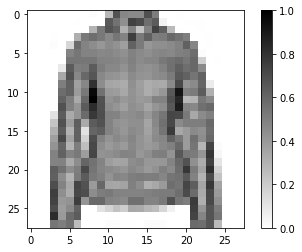

In [9]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

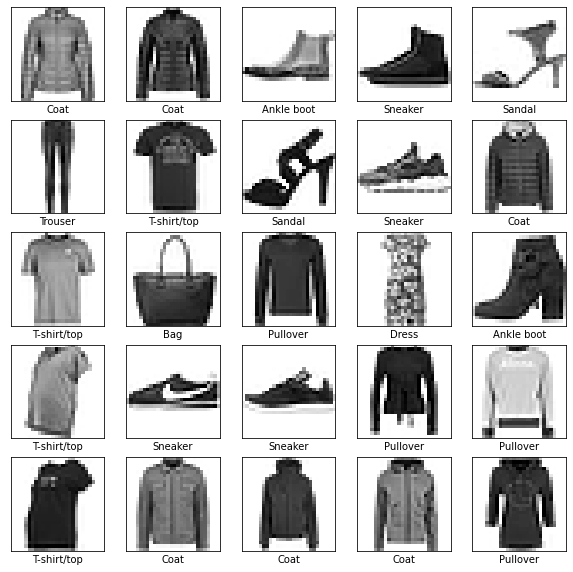

In [10]:
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
  image = image.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image, cmap=plt.cm.binary)
  plt.xlabel(class_names[label])
  i += 1
plt.show()

# **Build the model**
Building the neural network requires configuring the layers of the model, then compiling the model.

# **Setup the layers**
The basic building block of a neural network is the layer. A layer extracts a representation from the data fed into it.
Hopefully, a series of connected layers results in a representation that is meaningful for the problem at hand.


Much of deep learning consists of chaining together simple layers. Most layers, like tf.keras.layers.dense, have internal parameters which are adjusted ('Learning') during training.



In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

# **Compile the model**

Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:



*   Loss Function - An algorithm for measuring how far the model's outputs are from the desired output. The goal of training is this measures loss.
*   Optimizer - An algorithm for adjusting the inner parameters of the model in order to minimize loss.
*   Metrics - Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.






In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

**Training the model**

In [13]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [14]:
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 10s 2ms/step - loss: 0.4986 - accuracy: 0.8248
Epoch 2/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3708 - accuracy: 0.8673
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3378 - accuracy: 0.8789
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3119 - accuracy: 0.8854
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2887 - accuracy: 0.8927


**Evaluate accuracy**

In [15]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 2s 5ms/step - loss: 0.3403 - accuracy: 0.8776
Accuracy on test dataset: 0.8776000142097473


**Make predictions and explore**

In [16]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

1/1 [==============================] - 0s 83ms/step


In [17]:
predictions.shape

(32, 10)

In [18]:
predictions[0]

array([2.4113338e-05, 8.9383384e-06, 1.7671198e-02, 4.0649952e-06,
       9.1069388e-01, 2.6319533e-09, 7.1580335e-02, 7.6033855e-09,
       1.7500819e-05, 1.9868247e-08], dtype=float32)

In [19]:
np.argmax(predictions[0])

4

In [20]:
test_labels[0]

4

In [21]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Lets look at the 0th image, predictions, and prediction array.

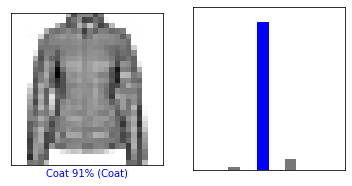

In [22]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

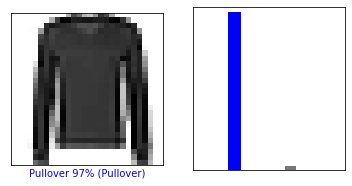

In [23]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

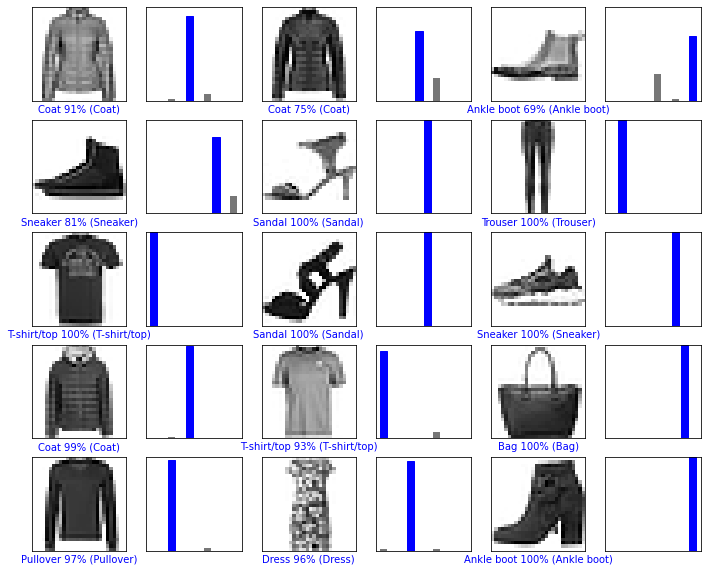

In [24]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)


Finally, use the trained model to make a prediction about a single image.

In [25]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


In [26]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


In [27]:
predictions_single = model.predict(img)

print(predictions_single)

1/1 [==============================] - 0s 41ms/step
[[2.4113315e-05 8.9383384e-06 1.7671185e-02 4.0649993e-06 9.1069388e-01
  2.6319533e-09 7.1580335e-02 7.6034148e-09 1.7500801e-05 1.9868247e-08]]


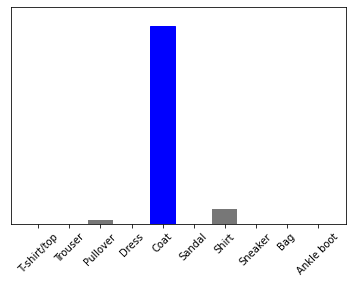

In [28]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [29]:
np.argmax(predictions_single[0])

4